# DGN with Bayesian Attention Modules (BAM)
DGN: https://arxiv.org/abs/1810.09202

BAM: https://arxiv.org/abs/2010.10604

Envionment: https://arxiv.org/abs/1712.00600

Reference codes: https://github.com/mlii/mfrl

In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import namedtuple
from dgl.nn.pytorch import GATConv
from torch.optim import Adam

Using backend: pytorch


## Replay Buffer for Graph Representation

In [3]:
Transition = namedtuple('Transition', ('graph', 'action', 'reward', 'next_graph', 'done'))


class GraphBuffer(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Save Transitions"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        samples = random.sample(self.memory, batch_size)
        
        graphs = [sample[0] for sample in samples]
        actions = [torch.LongTensor(sample[1]) for sample in samples]
        rewards = [torch.Tensor(sample[2]) for sample in samples]
        next_graphs = [sample[3] for sample in samples]
        dones = [torch.Tensor(sample[4]) for sample in samples]

        ret_graph = dgl.batch(graphs)
        ret_action = torch.cat(actions).reshape(-1, 1)
        ret_reward = torch.cat(rewards).reshape(-1)
        ret_next_graph = dgl.batch(next_graphs)
        ret_dones = torch.cat(dones).reshape(-1)
        
        return ret_graph, ret_action, ret_reward, ret_next_graph, ret_dones

    def __len__(self):
        return len(self.memory)

## Observation Encoder

\begin{equation}
h_{i}=\mathrm{MLP}(o_{i})
\end{equation}

In [10]:
class ObsEncoder(nn.Module):
    def __init__(self, in_dim, o_dim=128, h_dim=512):
        super(ObsEncoder, self).__init__()
        self.fc1 = nn.Linear(in_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, o_dim)
    
    def forward(self, o):
        o = F.relu(self.fc1(o))
        o = F.relu(self.fc2(o))
        return o

## Relational Kernel

\begin{equation}
\alpha_{i,j}^{m}=\frac{\exp(\tau\cdot \mathbf{W}_{Q}^{m}h_{i}\cdot(\mathbf{W}_{K}^{m}h_{j})^\top)}{\sum_{k\in\mathbb{B}_{+i}}\exp(\tau\cdot\mathbf{W}_{Q}^{m}h_{i}\cdot(\mathbf{W}_{K}^{m}h_{k})^{\top})}
\end{equation}

\begin{equation}
h_{i}^{'}=\sigma\left( \mathrm{concat}_{m\in M}\left[ \sum_{j\in\mathbb{B}_{+i}}\alpha_{i,j}^{m}\mathbf{W}_{v}^{m}h_{j} \right] \right)
\end{equation}

In [4]:
class DotGATLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(DotGATLayer, self).__init__()
        self.fc_q = nn.Linear(in_dim, out_dim)
        self.fc_k = nn.Linear(in_dim, out_dim)
        self.fc_v = nn.Linear(in_dim, out_dim)
        self.tau = 1/math.sqrt(out_dim)

    def edge_attention(self, edges):
        k = self.fc_k(edges.src['z'])
        q = self.fc_q(edges.dst['z'])
        a = (k*q).sum(-1, keepdims=True)*self.tau
        return {'e': a}

    def message_func(self, edges):
        return {'z': edges.src['z'], 'e': edges.data['e']}
    
    def reduce_func(self, nodes):
        s = nodes.mailbox['e']
        alpha = F.softmax(s, dim=1)
        v = self.fc_v(nodes.mailbox['z'])
        h = torch.sum(alpha * v, dim=1)
        return {'h': h}

    def forward(self, g, z):
        g.ndata['z'] = z
        g.apply_edges(self.edge_attention)
        g.update_all(self.message_func, self.reduce_func)
        h = g.ndata.pop('h')
        # delete all unnecessary variables
        g.ndata.pop('z')
        g.edata.pop('e')
        return h

class MultiHeadDotGATLayer(nn.Module):
    def __init__(self, in_dim, out_dim, num_heads):
        super(MultiHeadDotGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        h_dim = out_dim // num_heads
        assert (h_dim*num_heads) == out_dim
        for _ in range(num_heads):
            self.heads.append(DotGATLayer(in_dim, h_dim))

    def forward(self, g, h):
        hs = [head(g, h) for head in self.heads]
        h = F.relu(torch.cat(hs, dim=1))
        return h

## Relational Kernel with Bayesian Attention

### Latent random variable: unnormalized attention score

\begin{equation}
\mathrm{\Phi}_{i,j}^{m}=\tau\cdot \mathbf{W}_{Q}^{m}h_{i}\cdot(\mathbf{W}_{K}^{m}h_{j})^\top
\end{equation}

\begin{equation}
S_{i,j}^{m}\sim\log\mathcal{N}(\Phi_{i,j}^{m}-\sigma^{2}/2,\sigma^{2})
\end{equation}

### Reparametrization

\begin{equation}
S_{i,j}^{m}=g_{\phi}(\epsilon_{i,j}^{m})=\exp(\mathrm{\Phi}_{i,j}^{m})\exp(\epsilon_{i,j}^{m}\sigma-\sigma^{2}/2)
\\\epsilon_{i,j}^{m}\sim\mathcal{N}(0,1)
\end{equation}

### Key-based contextual prior

\begin{equation}
\Psi_{i,j}^{m}=\text{softmax}\left(\mathrm{MLP}(h_{j})\right)
\\
p_{\eta}(S_{i,j}^{m})=\log\mathcal{N}(\Psi_{i,j}^{m},\sigma_{0}^{2})
\end{equation}


### KL divergence

\begin{equation}
D_{\mathrm{KL}}\left(q_{\phi}(S_{i,j}^{m})||p_{\eta}(S_{i,j}^{m})\right)=\log\frac{\sigma_{0}}{\sigma}+\frac{\sigma^{2}+\left(\Phi_{i,j}^{m}-\Psi_{i,j}^{m}-\sigma^{2}/2\right)^{2}}{2\sigma_{0}^{2}}
\end{equation}

### Bayesian attention

\begin{equation}
\alpha_{i,j}^{m}=\frac{S_{i,j}^{m}}{\sum_{k\in\mathbb{B}_{+i}}S_{i,k}^{m}}
\end{equation}

\begin{equation}
h_{i}^{'}=\sigma\left( \mathrm{concat}_{m\in M}\left[ \sum_{j\in\mathbb{B}_{+i}}\alpha_{i,j}^{m}\mathbf{W}_{v}^{m}h_{j} \right] \right)
\end{equation}

In [5]:
class BayesGATLayer(nn.Module):
    def __init__(self, in_dim, out_dim,
                 se_dim, sigma, sigma_0):
        super(BayesGATLayer, self).__init__()
        self.fc_q = nn.Linear(in_dim, out_dim)
        self.fc_k = nn.Linear(in_dim, out_dim)
        self.fc_v = nn.Linear(in_dim, out_dim)
        self.tau = 1/math.sqrt(out_dim)

        self.sigma = torch.tensor(sigma).type(torch.float32)
        self.se_fc1 = nn.Linear(in_dim, se_dim)
        self.se_fc2 = nn.Linear(se_dim, 1)
        self.se_act = nn.ReLU()
        self.sigma_0 = torch.tensor(sigma_0).type(torch.float32)
        self.KL_backward = 0.

    def edge_attention(self, edges):
        k = edges.src['z']
        k2 = self.se_fc1(k)
        k2 = self.se_fc2(self.se_act(k2))
        k = self.fc_k(k)
        q = self.fc_q(edges.dst['z'])
        a = (k*q).sum(-1, keepdims=True)*self.tau
        
        return {'e': a, 'p': k2}
    
    def message_func(self, edges):
        return {'z': edges.src['z'], 'e': edges.data['e'], 'p': edges.data['p']}
    
    def reduce_func(self, nodes):
        s = nodes.mailbox['e']
        p = F.softmax(nodes.mailbox['p'], dim=1)
        mean_prior = torch.log(p+1e-20)
        alpha = F.softmax(s, dim=1)
        logprobs = torch.log(alpha+1e-20)
        if self.training:
            mean_posterior = logprobs - self.sigma**2 / 2
            out_weight = F.softmax(mean_posterior + self.sigma*torch.randn_like(logprobs), dim=1)
            KL = torch.log(self.sigma_0 / self.sigma + 1e-20) + (
                    self.sigma**2 + (mean_posterior - mean_prior)**2) / (2 * self.sigma_0**2) - 0.5
        else:
            out_weight = alpha
            KL = torch.zeros_like(out_weight)
        v = self.fc_v(nodes.mailbox['z'])
        h = torch.sum(out_weight * v, dim=1)
        return {'h': h, 'kl': KL.mean(dim=1)}

    def forward(self, g, z):
        g.ndata['z'] = z
        g.apply_edges(self.edge_attention)
        g.update_all(self.message_func, self.reduce_func)
        self.KL_backward = g.ndata.pop('kl').mean()
        h = g.ndata.pop('h')
        # delete all unnecessary variables
        g.ndata.pop('z')
        g.edata.pop('e')
        g.edata.pop('p')
        return h

class BayesMultiHeadGATLayer(nn.Module):
    def __init__(self, in_dim, out_dim, num_heads,
                 se_dim, sigma, sigma_0):
        super(BayesMultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        h_dim = out_dim // num_heads
        assert (h_dim*num_heads) == out_dim
        for _ in range(num_heads):
            self.heads.append(BayesGATLayer(in_dim, h_dim,
                                            se_dim, sigma, sigma_0))
        self.KL_backward = 0.

    def forward(self, g, h):
        hs = [head(g, h) for head in self.heads]
        KL = [head.KL_backward for head in self.heads]
        self.KL_backward = torch.mean(torch.stack(KL))
        h = F.relu(torch.cat(hs, dim=1))
        return h

## DGN Agent

\begin{equation}
Q(o_{i}, \cdot)=\mathrm{Linear}\left(\mathrm{concat}\left[ h_{i}, h_{i}^{'}, h_{i}^{''} \right]\right)
\end{equation}

In [8]:
class DGN_Conv(nn.Module):
    def __init__(self, obs_dim, h_dim=128, num_heads=8,
                 target=False):
        super(DGN_Conv, self).__init__()
        self.encoder = ObsEncoder(in_dim=obs_dim, o_dim=h_dim)
        self.conv1 = MultiHeadDotGATLayer(h_dim, h_dim, num_heads)
        self.conv2 = MultiHeadDotGATLayer(h_dim, h_dim, num_heads)
        self.target = target
    
    def forward(self, graph):
        obs = graph.ndata['obs']
        z1 = self.encoder(obs)
        z2 = self.conv1(graph, z1)
        z3 = self.conv2(graph, z2)
        out = torch.cat([z1, z2, z3], dim=1)
        return out

class DGNAgent(nn.Module):
    def __init__(self, obs_dim, act_dim, h_dim,
                 num_heads, gamma, batch_size,
                 buffer_size, lr, neighbors,
                 beta, *args, **kwargs):
        super(DGNAgent, self).__init__()
        self.conv_net = DGN_Conv(obs_dim, h_dim, num_heads)
        self.target_conv = DGN_Conv(obs_dim, h_dim, num_heads, target=True)
        self.q_net = nn.Linear(3*h_dim, act_dim)
        self.target_q = nn.Linear(3*h_dim, act_dim)
        self.target_conv.load_state_dict(self.conv_net.state_dict())
        self.target_q.load_state_dict(self.q_net.state_dict())
        self.optimizer = Adam(list(self.conv_net.parameters())+list(self.q_net.parameters()),
                              lr=lr)
        self.beta = beta
        self.gamma = gamma
        self.buffer = GraphBuffer(buffer_size)
        self.batch_size = batch_size
        
        self.n_act = act_dim
        self.n_neighbor = neighbors

        self._new_add = 0

    def get_action(self, graph, epsilon):
        if random.random() < self.epsilon:
            action = torch.randint(0, self.n_act, size=(graph.num_nodes(),))
        else:
            q_value = self.q_net(graph)
            action = q_value.argmax(dim=-1).detach()
        self.epsilon = max(self.epsilon*self.decay_rate, self.epsilon_min)

        return action.numpy().astype(np.int32)

    def get_q(self, graph):
        z = self.conv_net(graph)
        q = self.q_net(z)
        return q

    def get_target(self, graph):
        z = self.target_conv(graph)
        q = self.target_q(z)
        return q
    
    def save_samples(self, g, a, r, n_g, t):
        self.buffer.push(g, a, r, n_g, t)
        self._new_add += 1

    def train(self):
        batch_num = self._new_add * 2 // self.batch_size
        for _ in range(batch_num):
            state, act, reward, n_state, done = self.buffer.sample(self.batch_size)
            curr_qs = self.get_q(state)
            selected_qs = curr_qs.gather(1, act).reshape(-1)
            next_qs = self.get_target(n_state).max(dim=1)[0].detach()
            target = reward + self.gamma * next_qs * (1 - done)

            loss = F.mse_loss(selected_qs, target)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.update()
        
        self._new_add = 0

    def update(self):
        for target, param in zip(self.target_conv.parameters(),
                                  self.conv_net.parameters()):
            target.data = (1-self.beta)*target.data + self.beta*param.data

        for target, param in zip(self.target_q.parameters(),
                                  self.q_net.parameters()):
            target.data = (1-self.beta)*target.data + self.beta*param.data

## DGN Agent with Bayesian Attention

\begin{equation}
\mathcal{L}_{\mathrm{reg}}(\phi)=
\lambda_{t}\sum_{l=1}^{L}D_{\mathrm{KL}}\left(q_{\phi}(S^{l}\,|\,g_{\phi}(\mathbf{\epsilon}_{1:l-1}))||p_{\mathbf{\eta}}(S^{l}\,|\,g_{\phi}(\mathbf{\epsilon}_{1:l-1}))\right)
\end{equation}

In [10]:
class BayesDGN_Conv(nn.Module):
    def __init__(self, obs_dim, h_dim, num_heads,
                 se_dim, sigma, sigma_0, target=False):
        super(BayesDGN_Conv, self).__init__()
        self.encoder = ObsEncoder(in_dim=obs_dim, o_dim=h_dim)
        self.conv1 = BayesMultiHeadGATLayer(h_dim, h_dim, num_heads,
                                            se_dim, sigma, sigma_0)
        self.conv2 = BayesMultiHeadGATLayer(h_dim, h_dim, num_heads,
                                            se_dim, sigma, sigma_0)
        self.target = target
        if self.target:
            self.training = False

    def forward(self, graph):
        obs = graph.ndata['obs']
        z1 = self.encoder(obs)
        z2 = self.conv1(graph, z1)
        z3 = self.conv2(graph, z2)
        out = torch.cat([z1, z2, z3], dim=1)
        return out

    def kl(self):
        return self.conv1.KL_backward + self.conv2.KL_backward

class BayesDGNAgent(nn.Module):
    def __init__(self, obs_dim, act_dim, h_dim,
                 num_heads, gamma, batch_size,
                 buffer_size, lr, neighbors,
                 beta, rho, se_dim, sigma, sigma_0,
                 *args, **kwargs):
        super(BayesDGNAgent, self).__init__()
        self.conv_net = BayesDGN_Conv(obs_dim, h_dim, num_heads,
                                      se_dim, sigma, sigma_0)
        self.target_conv = BayesDGN_Conv(obs_dim, h_dim, num_heads,
                                         se_dim, sigma, sigma_0,
                                         target=True)
        self.q_net = nn.Linear(3*h_dim, act_dim)
        self.target_q = nn.Linear(3*h_dim, act_dim)
        self.target_conv.load_state_dict(self.conv_net.state_dict())
        self.target_q.load_state_dict(self.q_net.state_dict())
        self.optimizer = Adam(list(self.conv_net.parameters())+list(self.q_net.parameters()),
                              lr=lr)
        self.beta = beta
        self.gamma = gamma
        self.buffer = GraphBuffer(buffer_size)
        self.batch_size = batch_size

        self.n_act = act_dim
        self.n_neighbor = neighbors
        self.rho = torch.tensor(rho).type(torch.float32)
        self.t = 0

        self._new_add = 0

    def get_action(self, graph, epsilon):
        if random.random() < self.epsilon:
            action = torch.randint(0, self.n_act, size=(graph.num_nodes(),))
        else:
            q_value = self.get_q(graph)
            action = q_value.argmax(dim=-1).detach()

        return action.numpy().astype(np.int32)

    def get_q(self, graph):
        z = self.conv_net(graph)
        self.KL_backward = self.conv_net.kl()
        q = self.q_net(z)
        return q

    def get_target(self, graph):
        z = self.target_conv(graph)
        q = self.target_q(z)
        return q
    
    def save_samples(self, g, a, r, n_g, t):
        self.buffer.push(g, a, r, n_g, t)
        self._new_add += 1

    def train(self):
        batch_num = self._new_add * 2 // self.batch_size
        lamb_elbo = F.sigmoid(self.rho*self.t)
        for _ in range(batch_num):
            state, act, reward, n_state, done = self.buffer.sample(self.batch_size)
            curr_qs, curr_weight = self.get_q(state)
            selected_qs = curr_qs.gather(1, act).reshape(-1)
            next_qs = self.get_target(n_state).max(dim=1)[0].detach()
            target = reward + self.gamma * next_qs * (1 - done)

            KL = lamb_elbo*self.conv_net.kl()
            loss = F.mse_loss(selected_qs, target) + KL
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.update()
        self._new_add = 0
        self.t += 1

    def update(self):
        for target, param in zip(self.target_conv.parameters(),
                                  self.conv_net.parameters()):
            target.data = (1-self.beta)*target.data + self.beta*param.data

        for target, param in zip(self.target_q.parameters(),
                                  self.q_net.parameters()):
            target.data = (1-self.beta)*target.data + self.beta*param.data

## Get graph from observation

In [20]:
def get_edges(feature, n_agents, n_neighbor=3):
    from_idx = [] # source
    to_idx = [] # destination
    dis = []
    for src in range(n_agents):
        x, y = feature[src][-2], feature[src][-1]
        dis.append((x, y, src))
    for src in range(n_agents):
        f = []
        for dst in range(n_agents):
            distance = (dis[dst][0]-dis[src][0])**2+(dis[dst][1]-dis[src][1])**2
            f.append([distance, dst])
        f.sort(key=lambda x:x[0]) # sort w.r.t. distance
        for order in range(n_neighbor+1):
            from_idx.append(src)
            to_idx.append(f[order][1])
    return from_idx, to_idx

def observation(view, feature, n_agents, group):
    obs = []
    if group == 0:
        for j in range(n_agents):
            obs.append(np.hstack(((view[j][:,:,1]-view[j][:,:,5]).flatten(),
                                  feature[j][-1:-3:-1])))
    else:
        for j in range(n_agents):
            obs.append(np.hstack(((view[j][:,:,4]-view[j][:,:,2]).flatten(),
                                  feature[j][-1:-3:-1])))
    return obs

def gen_graph(view, feature, n_neighbor, group, g=None):
    """Get state as a graph"""
    n_agents = len(feature)
    
    if g is None:
        g = dgl.DGLGraph()

        g.add_nodes(n_agents)

        from_idx, to_idx = get_edges(feature, n_agents, n_neighbor)
        g.add_edges(from_idx, to_idx)
    
    # we save observation as the feature of the nodes
    obs = observation(view, feature, n_agents, group)
    g.ndata['obs'] = torch.Tensor(obs) # shape = (n_agents, view_size**2 + 2)

    return g

## Self-play with "Battle" Environment

In [23]:
def play(env, n_round, map_size, max_steps, handles, models, eps,
         print_every, n_neighbor=3, render=False, train=True):
    """play a ground and train"""
    env.reset()
    generate_map(env, map_size, handles)

    step_ct = 0
    done = False

    n_group = len(handles)
    state = [None for _ in range(n_group)]
    next_state = [None for _ in range(n_group)]
    acts = [None for _ in range(n_group)]

    alives = [None for _ in range(n_group)]
    rewards = [None for _ in range(n_group)]
    nums = [env.get_num(handle) for handle in handles]
    max_nums = nums.copy()

    print("\n\n[*] ROUND #{0}, EPS: {1:.2f} NUMBER: {2}".format(n_round, eps, nums))
    mean_rewards = [[] for _ in range(n_group)]
    total_rewards = [[] for _ in range(n_group)]

    # get graph from observation of each group

    while not done and step_ct < max_steps:
        # take actions for every group
        for i in range(n_group):
            view, feature = env.get_observation(handles[i])
            state[i] = gen_graph(view, feature, n_neighbor, i)
            acts[i] = models[i].act(graph=state[i], epsilon=eps)

        for i in range(n_group):
            env.set_action(handles[i], acts[i])

        # simulate one step
        done = env.step()

        for i in range(n_group):
            rewards[i] = env.get_reward(handles[i])
            alives[i] = env.get_alive(handles[i])
            view, feature = env.get_observation(handles[i])
            next_state[i] = gen_graph(view, feature, n_neighbor, i)

        buffer = {
            'g': state[0], 'a': acts[0], 'r': rewards[0],
            'n_g': next_state[0], 't': ~alives[0]
        }

        # save experience
        if train:
            models[0].save_samples(**buffer)

        # stat info
        nums = [env.get_num(handle) for handle in handles]

        for i in range(n_group):
            sum_reward = sum(rewards[i])
            rewards[i] = sum_reward / nums[i]
            mean_rewards[i].append(rewards[i])
            total_rewards[i].append(sum_reward)

        if render:
            env.render()

        # clear dead agents
        env.clear_dead()

        info = {"Ave-Reward": np.round(rewards, decimals=6), "NUM": nums}

        step_ct += 1

        if step_ct % print_every == 0:
            print("> step #{}, info: {}".format(step_ct, info))

    # train model after an episode ends
    if train:
        models[0].train()

    for i in range(n_group):
        mean_rewards[i] = sum(mean_rewards[i]) / len(mean_rewards[i])
        total_rewards[i] = sum(total_rewards[i])

    return max_nums, nums, mean_rewards, total_rewards

## Play "Battle" with trained models

In [22]:
def battle(env, n_round, map_size, max_steps, handles, models, eps,
           print_every, n_neighbor=3, render=False):
    """play a ground"""
    env.reset()
    generate_map(env, map_size, handles)

    step_ct = 0
    done = False

    n_group = len(handles)
    state = [None for _ in range(n_group)]
    acts = [None for _ in range(n_group)]

    alives = [None for _ in range(n_group)]
    rewards = [None for _ in range(n_group)]
    nums = [env.get_num(handle) for handle in handles]
    max_nums = nums.copy()

    print("\n\n[*] ROUND #{0}, EPS: {1:.2f} NUMBER: {2}".format(n_round, eps, nums))
    mean_rewards = [[] for _ in range(n_group)]
    total_rewards = [[] for _ in range(n_group)]

    while not done and step_ct < max_steps:
        # take actions for every model
        for i in range(n_group):
            view, feature = env.get_observation(handles[i])
            state[i] = gen_graph(view, feature, n_neighbor, i)
            acts[i] = models[i].act(graph=state[i], epsilon=eps)

        for i in range(n_group):
            env.set_action(handles[i], acts[i])

        # simulate one step
        done = env.step()

        for i in range(n_group):
            rewards[i] = env.get_reward(handles[i])
            alives[i] = env.get_alive(handles[i])

        # stat info
        nums = [env.get_num(handle) for handle in handles]

        for i in range(n_group):
            sum_reward = sum(rewards[i])
            rewards[i] = sum_reward / nums[i]
            mean_rewards[i].append(rewards[i])
            total_rewards[i].append(sum_reward)

        if render:
            env.render()

        # clear dead agents
        env.clear_dead()

        info = {"Ave-Reward": np.round(rewards, decimals=6), "NUM": nums}

        step_ct += 1

        if step_ct % print_every == 0:
            print("> step #{}, info: {}".format(step_ct, info))

    for i in range(n_group):
        mean_rewards[i] = sum(mean_rewards[i]) / len(mean_rewards[i])
        total_rewards[i] = sum(total_rewards[i])

    return max_nums, nums, mean_rewards, total_rewards

## Need to do

Play with different models (vs IL, MFQ, DGN, ...) ("./battle.py)

In [1]:
import numpy as np
import os
import pandas as pd

from matplotlib import pyplot as plt

base_dir = 'data/tmp'

In [6]:
algos = {'dgn':'DGN', 'bayes_dgn':'BAM-DGN'}
rst = dict()

for algo in algos.keys():
    rst_dir = os.path.join(base_dir, algo)
    rst[algo] = pd.read_csv(os.path.join(rst_dir, 'total_reward.txt'), sep='\t', header=None).values

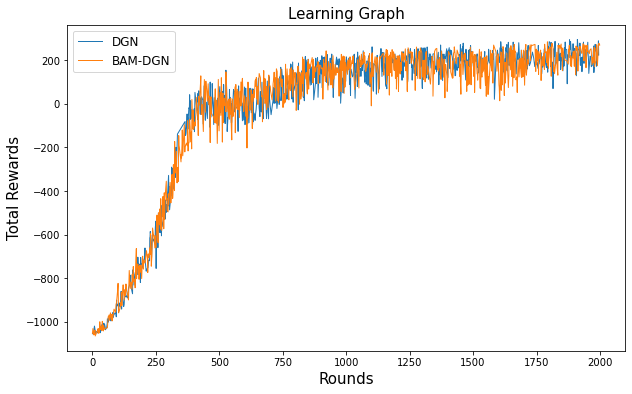

In [7]:
plt.figure(figsize=(10,6))

for i, algo in enumerate(algos.keys()):
    data = rst[algo]
    idx, values = data[:, 0], data[:, 1]
    plt.plot(idx, values, linewidth=1, color='C%d' % i, label=algos[algo])

plt.legend(fontsize=12)
plt.xlabel('Rounds', fontsize=15)
plt.ylabel('Total Rewards', fontsize=15)
plt.title('Learning Graph', fontsize=15)
plt.savefig(os.path.join(base_dir, 'rst.png'))
plt.show()

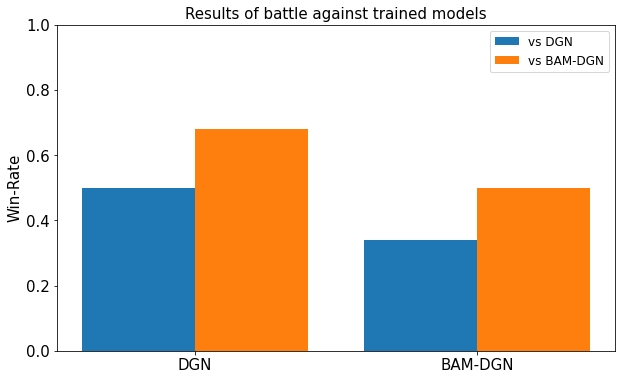

In [19]:
def create_x(t, w, n, d):
    return [t*x + w*n for x in range(d)]

value_a = [0.5, 0.34]
value_b = [0.68, 0.5]

value_a_x = create_x(2, 0.8, 1, 2)
value_b_x = create_x(2, 0.8, 2, 2)

plt.figure(figsize=(10, 6))
plt.bar(value_a_x, value_a, label='vs DGN')
plt.bar(value_b_x, value_b, label='vs BAM-DGN')
middle_x = [(a+b)/2 for (a,b) in zip(value_a_x, value_b_x)]

plt.xticks(middle_x, ['DGN', 'BAM-DGN'], fontsize=15)
plt.title('Results of battle against trained models', fontsize=15)
plt.ylabel('Win-Rate', fontsize=15)
plt.ylim(0.0, 1.0)
plt.yticks(fontsize=15)
plt.legend(fontsize=12)
plt.savefig(os.path.join(base_dir, 'winrate.png'))
plt.show()